# Benchmark Throughput experiment (Switch)
This notebook will show you how to measure the throughput between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* The Alveo cards are connected to a switch
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

In [1]:
from vnx_utils import *
import pynq

In [2]:
import sys
import os

In [3]:
workers = pynq.Device.devices

## Download xclbin to Alveo cards
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [4]:
xclbin = '/home/ubuntu/Projects/StaRR-NIC/xup_vitis_network_example/benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin, device=workers[0])

## Check Link 

We are going to use the function `linkStatus` that reports if the CMAC is detecting link, which means that the physical connection
between each Alveo card and the switch is established.

In [5]:
print("Link worker 0_0 {}, worker 0_1 {}".format(ol_w0.cmac_0.linkStatus(), ol_w0.cmac_1.linkStatus()))

Link worker 0_0 {'cmac_link': True}, worker 0_1 {'cmac_link': True}


## Configure IP address of the Alveo cards
In the next cell we are going to configure the IP address of the two Alveo cards

In [6]:
ip_w0_0, ip_w0_1 = '10.0.0.47', '10.0.0.45'
if_status_w0_0 = ol_w0.networklayer_0.updateIPAddress(ip_w0_0, debug=True)
if_status_w0_1 = ol_w0.networklayer_1.updateIPAddress(ip_w0_1, debug=True)
print("Worker 0_0: {}\nWorker 0_1: {}".format(if_status_w0_0, if_status_w0_1))

Worker 0_0: {'HWaddr': '00:0a:35:02:9d:2f', 'inet addr': '10.0.0.47', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}
Worker 0_1: {'HWaddr': '00:0a:35:02:9d:2d', 'inet addr': '10.0.0.45', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}


## One way experiment with XL710

In [7]:
n3_data = {
    'ip_tx_0': '10.0.0.55',
    'ip_rx_1': '10.0.0.57',
    'mac_rx_1': '00:0a:35:86:00:01',
    'mac_tx_0': '00:0a:35:86:00:00',
    'sport': 64000,
    'dport': 64001,
}

tx_src_port, tx_dst_port = 60512, 62177
tx_dst_ip = n3_data['ip_rx_1']
tx_dst_mac = n3_data['mac_rx_1']

# The ports are from the reference of n5 (not in the packet)
rx_src_port, rx_dst_port = n3_data['dport'], n3_data['sport']
rx_src_ip = n3_data['ip_tx_0']
rx_src_mac = n3_data['mac_tx_0']

### Configure port 0

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [8]:
ol_w0.networklayer_0.resetDebugProbes()
ol_w0.networklayer_0.sockets[12] = (tx_dst_ip, tx_dst_port, tx_src_port, True)
ol_w0.networklayer_0.sockets[1] = (rx_src_ip, rx_dst_port, rx_src_port, True)
ol_w0.networklayer_0.populateSocketTable()

ol_w0.networklayer_0.invalidateARPTable()
ol_w0.networklayer_0.arpDiscovery()
ol_w0.networklayer_0.write_arp_entry(tx_dst_mac, tx_dst_ip)
ol_w0.networklayer_0.write_arp_entry(rx_src_mac, rx_src_ip)
ol_w0.networklayer_0.readARPTable()

{45: {'MAC address': '00:0a:35:02:9d:2d', 'IP address': '10.0.0.45'},
 55: {'MAC address': '00:0a:35:86:00:00', 'IP address': '10.0.0.55'},
 57: {'MAC address': '00:0a:35:86:00:01', 'IP address': '10.0.0.57'},
 61: {'MAC address': '40:a6:b7:22:ab:88', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:88', 'IP address': '10.0.0.63'}}

In [9]:
ol_w0.networklayer_0.getDebugProbes

{'tx_path': {'arp': {'packets': 256, 'bytes': 15360, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet': {'packets': 256, 'bytes': 15360, 'cycles': 2041},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0}},
 'rx_path': {'ethernet': {'packets': 3, 'bytes': 180, 'cycles': 46573},
  'packet_handler': {'packets': 3, 'bytes': 180, 'cycles': 46573},
  'arp': {'packets': 3, 'bytes': 180, 'cycles': 46573},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0}}}

### Configure port 1

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [10]:
ol_w0.networklayer_1.resetDebugProbes()
ol_w0.networklayer_1.sockets[1] = (rx_src_ip, rx_dst_port, rx_src_port, True)
ol_w0.networklayer_1.populateSocketTable()

ol_w0.networklayer_1.invalidateARPTable()
ol_w0.networklayer_1.arpDiscovery()
ol_w0.networklayer_1.write_arp_entry(tx_dst_mac, tx_dst_ip)
ol_w0.networklayer_1.write_arp_entry(rx_src_mac, rx_src_ip)
ol_w0.networklayer_1.readARPTable()

{47: {'MAC address': '00:0a:35:02:9d:2f', 'IP address': '10.0.0.47'},
 55: {'MAC address': '00:0a:35:86:00:00', 'IP address': '10.0.0.55'},
 57: {'MAC address': '00:0a:35:86:00:01', 'IP address': '10.0.0.57'},
 61: {'MAC address': '40:a6:b7:22:ab:88', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:88', 'IP address': '10.0.0.63'}}

In [11]:
ol_w0.networklayer_1.getDebugProbes

{'tx_path': {'arp': {'packets': 256, 'bytes': 15360, 'cycles': 2043},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet': {'packets': 256, 'bytes': 15360, 'cycles': 2043},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0}},
 'rx_path': {'ethernet': {'packets': 3, 'bytes': 180, 'cycles': 47699},
  'packet_handler': {'packets': 3, 'bytes': 180, 'cycles': 47699},
  'arp': {'packets': 3, 'bytes': 180, 'cycles': 47699},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0}}}

## Configure application
* Configure port 1 traffic generator 1 in `CONSUMER` mode

In [12]:
ol_w0_1_tg = ol_w0.traffic_generator_1_1
ol_w0_1_tg.register_map.debug_reset = 1
ol_w0_1_tg.register_map.mode = benchmark_mode.index('CONSUMER')
ol_w0_1_tg.register_map.CTRL.AP_START = 1
ol_w0_1_tg.resetProbes()

In [13]:
ol_w0_1_tg.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=3),
  dest_id = Register(value=0),
  number_packets = Register(value=0),
  number_beats = Register(value=0),
  time_between_packets = Register(value=0),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=0),
  out_traffic_cycles = Register(value=0),
  out_traffic_bytes = Register(value=0),
  out_traffic_packets = Register(value=0),
  in_traffic_cycles = Register(value=0),
  in_traffic_bytes = Register(value=0),
  in_traffic_packets = Register(value=0),
  summary_cycles = Register(value=0),
  summary_bytes = Register(value=0),
  summary_packets = Register(value=0),
  debug_reset = Register(value=0)
}

In [14]:
# for i in range(2):
#     for j in range(4):
#         ol_tg = getattr(ol_w0, 'traffic_generator_{}_{}'.format(i, j))
#         print(ol_tg.register_map)

* Configure port 0 traffic generator 0
* Run the application for different packet sizes
* Compute and store results for both local (Tx) and remote (Rx)

In [15]:
import time
freq = int(ol_w0.clock_dict['clock0']['frequency'])
freq

294

In [16]:
ol_w0_0_tg = ol_w0.traffic_generator_0_3
experiment_dict = {}
local_dict = {}
ol_w0_0_tg.register_map.mode = benchmark_mode.index('PRODUCER')
ol_w0_0_tg.register_map.dest_id = 12
ol_w0_0_tg.resetProbes()
ol_w0_1_tg.freq = freq
ol_w0_0_tg.freq = freq

In [17]:
ol_w0_0_tg.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=0),
  dest_id = Register(value=12),
  number_packets = Register(value=6960000000),
  number_beats = Register(value=2),
  time_between_packets = Register(value=0),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=0),
  out_traffic_cycles = Register(value=0),
  out_traffic_bytes = Register(value=0),
  out_traffic_packets = Register(value=0),
  in_traffic_cycles = Register(value=0),
  in_traffic_bytes = Register(value=0),
  in_traffic_packets = Register(value=0),
  summary_cycles = Register(value=0),
  summary_bytes = Register(value=0),
  summary_packets = Register(value=0),
  debug_reset = Register(value=0)
}

In [18]:
beats = 2
payload = beats * 64
pkt = 10_000
ol_w0_0_tg.register_map.debug_reset = 1
ol_w0_1_tg.register_map.debug_reset = 1
ol_w0_0_tg.register_map.time_between_packets = 0
ol_w0_0_tg.register_map.number_packets = pkt
local_dict = {}
ol_w0_0_tg.register_map.number_beats = beats
ol_w0_0_tg.register_map.CTRL.AP_START = 1
while int(ol_w0_0_tg.register_map.out_traffic_packets) != pkt:
    time.sleep(1)
    print(ol_w0_0_tg.register_map)
    print(ol_w0_1_tg.register_map)

In [19]:
# Get results from local and remote worker
tx_tot_pkt, tx_thr, tx_time = ol_w0_0_tg.computeThroughputApp('tx')
rx_tot_pkt, rx_thr, rx_time = ol_w0_1_tg.computeThroughputApp('rx')
#Create dict entry for this particular experiment
entry_dict = {'size': (beats * payload), 'rx_pkts' : rx_tot_pkt, 'tx_thr': tx_thr, 'rx_thr': rx_thr}
local_dict[beats] = entry_dict
# Reset probes to prepare for next computation
ol_w0_0_tg.resetProbes()
ol_w0_1_tg.resetProbes()
#Compute theoretical maximum at application level, overhead is UDP (8), IP (20), Ethernet(14) and FCS (4)
theoretical = (beats * 64 * 100)/((beats * 64)+8+20+14+4) 
print("Sent {:14,} size: {:4}-Byte done!	Got {:14,} took {:8.4f} sec, thr: {:.3f} Gbps, theoretical: {:.3f} Gbps, difference: {:6.3f} Gbps"\
      .format(pkt,beats*64, rx_tot_pkt, rx_time, rx_thr, theoretical, theoretical-rx_thr))
time.sleep(0.5)
experiment_dict[pkt] = local_dict
print("Frame level throughput: {}".format(rx_thr / ((beats * 64)/((beats * 64)+8+20+14+4))))

Sent         10,000 size:  128-Byte done!	Got         10,000 took   0.0002 sec, thr: 60.205 Gbps, theoretical: 73.563 Gbps, difference: 13.358 Gbps
Frame level throughput: 81.84141585841417


In [20]:
tx_tot_pkt, tx_thr, tx_time

(10000, 60.98942506381426, 0.00016789795918367348)

In [21]:
# for pkt in [1_000_000, 1_000_000_000]:
for pkt in [1_000_000, 1_000_000_000]:
    ol_w0_0_tg.register_map.debug_reset = 1
    ol_w0_1_tg.register_map.debug_reset = 1
    ol_w0_0_tg.register_map.time_between_packets = 0
    ol_w0_0_tg.register_map.number_packets = pkt
    local_dict = {}
    for i in range(23):
        beats = i + 1
        ol_w0_0_tg.register_map.number_beats = beats
        ol_w0_0_tg.register_map.CTRL.AP_START = 1
        while int(ol_w0_0_tg.register_map.out_traffic_packets) != pkt:
            time.sleep(0.8)
        # Get results from local and remote worker
        rx_tot_pkt, rx_thr, rx_time = ol_w0_1_tg.computeThroughputApp('rx')
        tx_tot_pkt, tx_thr, tx_time = ol_w0_0_tg.computeThroughputApp('tx')
        #Create dict entry for this particular experiment
        entry_dict = {'size': (beats * 64), 'rx_pkts' : rx_tot_pkt, 'tx_thr': tx_thr, 'rx_thr': rx_thr}
        local_dict[beats] = entry_dict
        # Reset probes to prepare for next computation
        ol_w0_0_tg.resetProbes()
        ol_w0_1_tg.resetProbes()
        #Compute theoretical maximum at application level, overhead is UDP (8), IP (20), Ethernet(14) and FCS (4)
        theoretical = (beats * 64 * 100)/((beats*64)+8+20+14+4) 
        print("Sent {:14,} size: {:4}-Byte done!	Got {:14,} took {:8.4f} sec, thr: {:.3f} Gbps, theoretical: {:.3f} Gbps, difference: {:6.3f} Gbps"\
              .format(pkt,beats*64, rx_tot_pkt, rx_time, rx_thr, theoretical, theoretical-rx_thr))
        time.sleep(0.5)
    experiment_dict[pkt] = local_dict

Sent      1,000,000 size:   64-Byte done!	Got      1,000,000 took   0.0103 sec, thr: 49.908 Gbps, theoretical: 58.182 Gbps, difference:  8.274 Gbps
Sent      1,000,000 size:  128-Byte done!	Got      1,000,000 took   0.0170 sec, thr: 60.211 Gbps, theoretical: 73.563 Gbps, difference: 13.352 Gbps
Sent      1,000,000 size:  192-Byte done!	Got      1,000,000 took   0.0204 sec, thr: 75.264 Gbps, theoretical: 80.672 Gbps, difference:  5.408 Gbps
Sent      1,000,000 size:  256-Byte done!	Got      1,000,000 took   0.0254 sec, thr: 80.596 Gbps, theoretical: 84.768 Gbps, difference:  4.172 Gbps
Sent      1,000,000 size:  320-Byte done!	Got      1,000,000 took   0.0305 sec, thr: 84.042 Gbps, theoretical: 87.432 Gbps, difference:  3.390 Gbps
Sent      1,000,000 size:  384-Byte done!	Got      1,000,000 took   0.0355 sec, thr: 86.507 Gbps, theoretical: 89.302 Gbps, difference:  2.795 Gbps
Sent      1,000,000 size:  448-Byte done!	Got      1,000,000 took   0.0406 sec, thr: 88.358 Gbps, theoretical: 9

## Plot the results
Finally we can plot the results using matplotlib

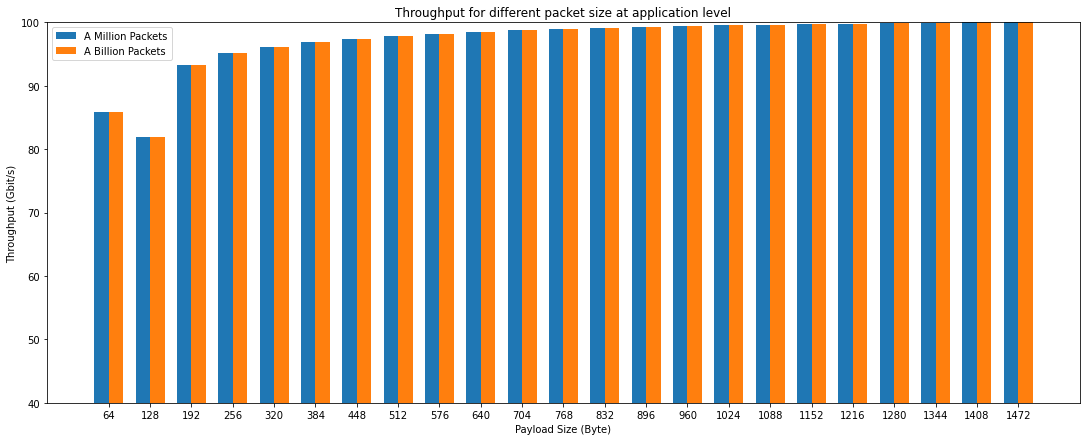

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

dict_oneM = experiment_dict[1_000_000]
dict_oneB = experiment_dict[1_000_000_000]
labels = []
oneM_thr = []
oneB_thr = []

for b in dict_oneM:
    labels.append(dict_oneM[b]['size'])
    # oneM_thr.append(dict_oneM[b]['rx_thr']
    dict_oneM[b]['pkt_thr'] = dict_oneM[b]['rx_thr'] * ((dict_oneM[b]['size'] + 46) / (dict_oneM[b]['size']))
    oneM_thr.append(dict_oneM[b]['pkt_thr'])

for b in dict_oneB:
    # oneB_thr.append(dict_oneB[b]['rx_thr'])
    dict_oneB[b]['pkt_thr'] = dict_oneB[b]['rx_thr'] * ((dict_oneB[b]['size'] + 46) / (dict_oneB[b]['size']))
    oneB_thr.append(dict_oneB[b]['pkt_thr'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, oneM_thr, width, label='A Million Packets')
if(len(oneB_thr) > 0):
    rects2 = ax.bar(x + width/2, oneB_thr, width, label='A Billion Packets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput (Gbit/s)')
ax.set_xlabel('Payload Size (Byte)')
ax.set_title('Throughput for different packet size at application level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(40,100)
fig.set_size_inches(18.5, 7)
plt.show()

In [25]:
for b in dict_oneM:
    print(dict_oneM[b]["size"], dict_oneM[b]["pkt_thr"])

64 85.77862536702588
128 81.84955089026946
192 93.29587560549919
256 95.07862782890119
320 96.12266439708887
384 96.86969399785471
448 97.43074182548976
512 97.8675222190273
576 98.21722534243744
640 98.50351425856245
704 98.74221229575645
768 98.94428585338083
832 99.1175608468125
896 99.26778058023952
960 99.39923442687059
1024 99.51526326580525
1088 99.61842979496294
1152 99.71074041938446
1216 99.7938578557223
1280 99.86904554714032
1344 99.93741989489772
1408 99.99985964144003
1472 100.05709163145194


## Release Alveo cards
To release the alveo cards the pynq overlay is freed

In [ ]:
payloads = []
multiplier = []
for b in dict_oneM:
    payloads.append(b)
    multiplier.append((dict_oneM[b]['size'] + 46) / (dict_oneM[b]['size']))
    
fig, ax = plt.subplots()
ax.plot(payloads, multiplier)
ax.set_xlabel('Payload size (bytes)')
ax.set_ylabel('Multiplier for app to frame level thr')
plt.show()

In [ ]:
pynq.Overlay.free(ol_w0)

In [ ]:
time_sec = 121.3707
frame_size = (23 * 64) + 46
pkts = 1e9

gbps = frame_size * pkts * 8 / time_sec / 1e9
gbps

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.